In [1]:
# !pip install python-docx wordcloud spacy langdetect --quiet

In [2]:
# !python3 -m spacy download fr_core_news_sm
# !python3 -m spacy download en_core_web_sm

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('comments_combined_cleaned_sentiment.csv')

In [5]:
# df = pd.DataFrame({
#   'comments' : df['comments'].str.split('\n').explode().tolist(),
# })

In [6]:
df.head()

,Unnamed: 0,comments,Service
0,0,C'est pas petit réseau orange,Orange Money
1,1,Oui,Orange Money
2,2,Plus pertinents,Orange Money
3,3,Aka laissez les gens tranquille. Vous manquez ...,Orange Money
4,4,Il y'a pas CMR sur ça,Orange Money


In [7]:
def text_cleaning(texts, nlp_model, n_process=4):
    """Nettoie les textes avec un modèle spaCy donné"""
    docs = nlp_model.pipe(texts, n_process=n_process, disable=["parser", "ner"])

    cleaned_texts = []

    for doc in docs:
        tokens = []
        for token in doc:
            if (not token.is_stop and          # Pas un mot vide
                not token.is_punct and         # Pas de ponctuation
                not token.is_space and         # Pas un espace
                not token.like_num and         # Pas un nombre
                not token.is_currency and      # Pas une devise
                len(token.text) > 2 and        # Plus de 2 caractères
                token.text.isalpha() and       # Seulement des lettres
                len(token.lemma_) > 2):   
                tokens.append(token.lemma_)
        cleaned_texts.append(" ".join(tokens))

    return cleaned_texts

In [8]:
!uv pip install transformers

Using Python 3.12.3 environment at: /home/angelvis/Documents/python-code/.venv


Audited 1 package in 30ms


In [9]:
from transformers import pipeline


def analyser_sentiment_transformers(texte, langue='fr'):
    def detect_label(label):
        if '1' in label or '2' in label:
            return 'NEGATIVE'
        elif '4' in label or '5' in label:
            return 'POSITIVE'
        else:
            return 'NEUTRAL'
        

    """Analyse le sentiment avec un modèle transformer"""
    # Pour le français
    if langue == 'fr':
        classifier = pipeline("sentiment-analysis", 
                            model="nlptown/bert-base-multilingual-uncased-sentiment")
    else:
        classifier = pipeline("sentiment-analysis")
    
    resultat = classifier(texte)[0]
    score = resultat['score']
    return detect_label(resultat['label'])



In [10]:
analyser_sentiment_transformers("En tout cas depuis l'arrivée de WAVE on règle facilement les choses. Ça réduit les\ palabres sur monnaie.\
Mais, moi j'attends mon gros cadeau, je suis fatigué de gagner 50 FRS ou rien")

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /nlptown/bert-base-multilingual-uncased-sentiment/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x760fc85f53d0>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 4b725fd8-603b-4fd8-a07b-3fe9f2843afc)')' thrown while requesting HEAD https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /nlptown/bert-base-multilingual-uncased-sentiment/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x760fc85f4980>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: bca7e494-0b42-429d-ba48-aa9e37a4e3ca)')' th

'NEUTRAL'

In [11]:
nlp_model_fr = spacy.load("fr_core_news_sm")

In [12]:
def text_cleaning_with_sentiment_detection(df, text_column='comments', n_process=4):
    # Créer une copie pour éviter les warnings
    df = df.copy()
    
    # Initialiser la colonne clean_sentence
    df['clean_sentence'] = ''
    
    # Nettoyer les textes français
    cleaned_fr = text_cleaning(
        df[text_column].tolist(), 
        nlp_model_fr, 
        n_process=n_process
    )

    df['clean_sentence'] = cleaned_fr
    df['sentiment'] = df['clean_sentence'].apply(lambda x: analyser_sentiment_transformers(x, langue='fr'))
    return df

In [13]:
df = text_cleaning_with_sentiment_detection(df, text_column='comments', n_process=4)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [14]:
df[['comments', 'sentiment', 'clean_sentence']].head()

,comments,sentiment,clean_sentence
0,C'est pas petit réseau orange,NEUTRAL,petit réseau orange
1,Oui,NEUTRAL,Oui
2,Plus pertinents,POSITIVE,pertinent
3,Aka laissez les gens tranquille. Vous manquez ...,NEUTRAL,aka laisser tranquille manquer promo simple me...
4,Il y'a pas CMR sur ça,NEUTRAL,CMR


In [15]:
df['clean_sentence'] = df.clean_sentence.str.lower()
df = df.drop_duplicates(subset=['clean_sentence'], keep='first')
df = df[df.clean_sentence != '']

In [16]:
df

,Unnamed: 0,comments,Service,clean_sentence,sentiment
0,0,C'est pas petit réseau orange,Orange Money,petit réseau orange,NEUTRAL
1,1,Oui,Orange Money,oui,NEUTRAL
2,2,Plus pertinents,Orange Money,pertinent,POSITIVE
3,3,Aka laissez les gens tranquille. Vous manquez ...,Orange Money,aka laisser tranquille manquer promo simple me...,NEUTRAL
4,4,Il y'a pas CMR sur ça,Orange Money,cmr,NEUTRAL
...,...,...,...,...,...
3456,1418,Carte sim svp,WAVE,carte sim svp,POSITIVE
3458,1420,Chemin numéro 3,WAVE,chemin numéro,NEGATIVE
3460,1422,"Wave Côte d'Ivoire\nquel wé de ""pas de chance""...",WAVE,wave côte ivoire chance fois suite aimer hein,POSITIVE
3461,1423,Numéro 2 a la plus grande chance,WAVE,numéro grand chance,POSITIVE


Text(0.5, 1.0, 'Nuage de Mots Orange Money')

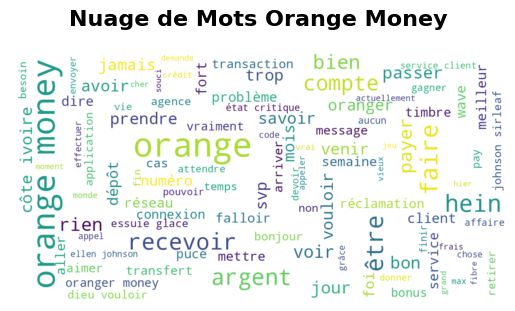

In [27]:
# Compter les fréquences
clean_text = " ".join(df[df['Service'] == 'Orange Money'].clean_sentence.tolist())

# Créer le nuage de mots
wordcloud = WordCloud(
    width=1200, 
    height=600,
    background_color='white',
    max_words=100,
    colormap='viridis',
    prefer_horizontal=0.7,
    min_font_size=10,
    max_font_size=80,
    relative_scaling=0.5
).generate(clean_text)

# Nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots Orange Money', fontsize=16, fontweight='bold', pad=20)

Text(0.5, 1.0, 'Nuage de Mots WAVE')

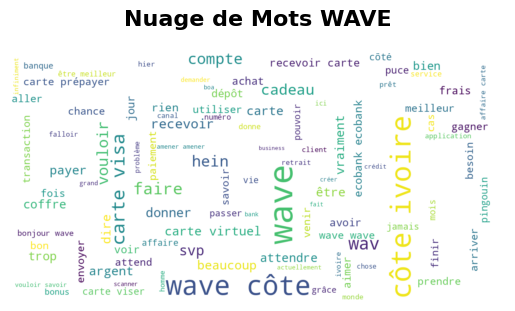

In [28]:
# Compter les fréquences
clean_text = " ".join(df[df['Service'] == 'WAVE'].clean_sentence.tolist())

# Créer le nuage de mots
wordcloud = WordCloud(
    width=1200, 
    height=600,
    background_color='white',
    max_words=100,
    colormap='viridis',
    prefer_horizontal=0.7,
    min_font_size=10,
    max_font_size=80,
    relative_scaling=0.5
).generate(clean_text)

# Nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots WAVE', fontsize=16, fontweight='bold', pad=20)

In [29]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,           
    max_df=0.8,         
    ngram_range=(1, 2), 
    stop_words=None     
)
    
tfidf_matrix = vectorizer.fit_transform(df.clean_sentence)

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
inertias = []
n_clusters_range = range(2, min(11, len(df) // 2))  


scaler = StandardScaler(with_mean=False) 
tfidf_scaled = scaler.fit_transform(tfidf_matrix)

print("🔍 Recherche du nombre optimal de clusters...")


for k in n_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_scaled)
    
    silhouette = silhouette_score(tfidf_scaled, cluster_labels)
    silhouette_scores.append(silhouette)
    inertias.append(kmeans.inertia_)
    

best_k = n_clusters_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nMeilleur nombre de clusters: {best_k}")

🔍 Recherche du nombre optimal de clusters...

Meilleur nombre de clusters: 4


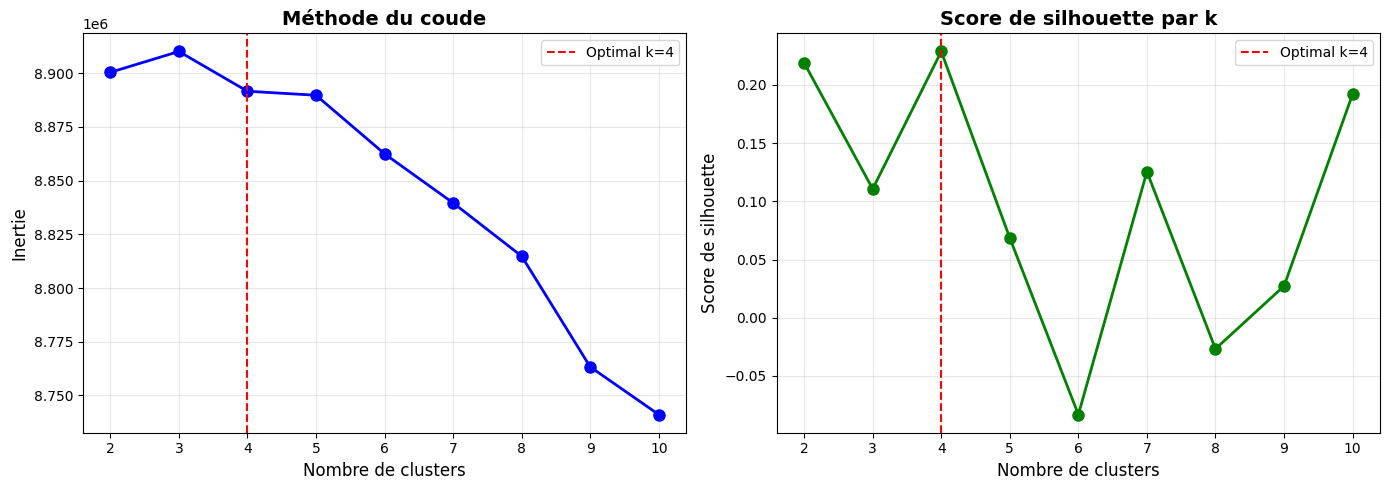

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Courbe du coude (Elbow method)
ax1.plot(n_clusters_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k={best_k}')
ax1.set_xlabel('Nombre de clusters', fontsize=12)
ax1.set_ylabel('Inertie', fontsize=12)
ax1.set_title('Méthode du coude', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Silhouette score
ax2.plot(n_clusters_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k={best_k}')
ax2.set_xlabel('Nombre de clusters', fontsize=12)
ax2.set_ylabel('Score de silhouette', fontsize=12)
ax2.set_title('Score de silhouette par k', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [32]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

<Axes: xlabel='cluster'>

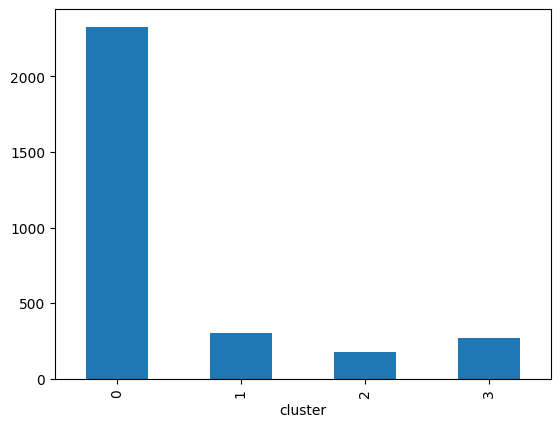

In [33]:
df['cluster'].value_counts().sort_index().plot(kind="bar")

In [34]:
# Distribution des clusters
print("\nDistribution des documents par cluster:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   Cluster {cluster_id}: {count} documents ({percentage:.1f}%)")

# Statistiques
if 'clean_sentence' in df.columns:
    df['nb_mots'] = df['clean_sentence'].apply(lambda x: len(str(x).split()))
    
    print("\nLongueur moyenne par cluster:")
    stats = df.groupby('cluster')['nb_mots'].agg(['mean', 'min', 'max']).round(1)
    print(stats)


Distribution des documents par cluster:
   Cluster 0: 2327 documents (75.7%)
   Cluster 1: 305 documents (9.9%)
   Cluster 2: 175 documents (5.7%)
   Cluster 3: 267 documents (8.7%)

Longueur moyenne par cluster:
         mean  min  max
cluster                
0         5.9    1  141
1         9.0    1   47
2         5.7    1   32
3         9.1    1   82


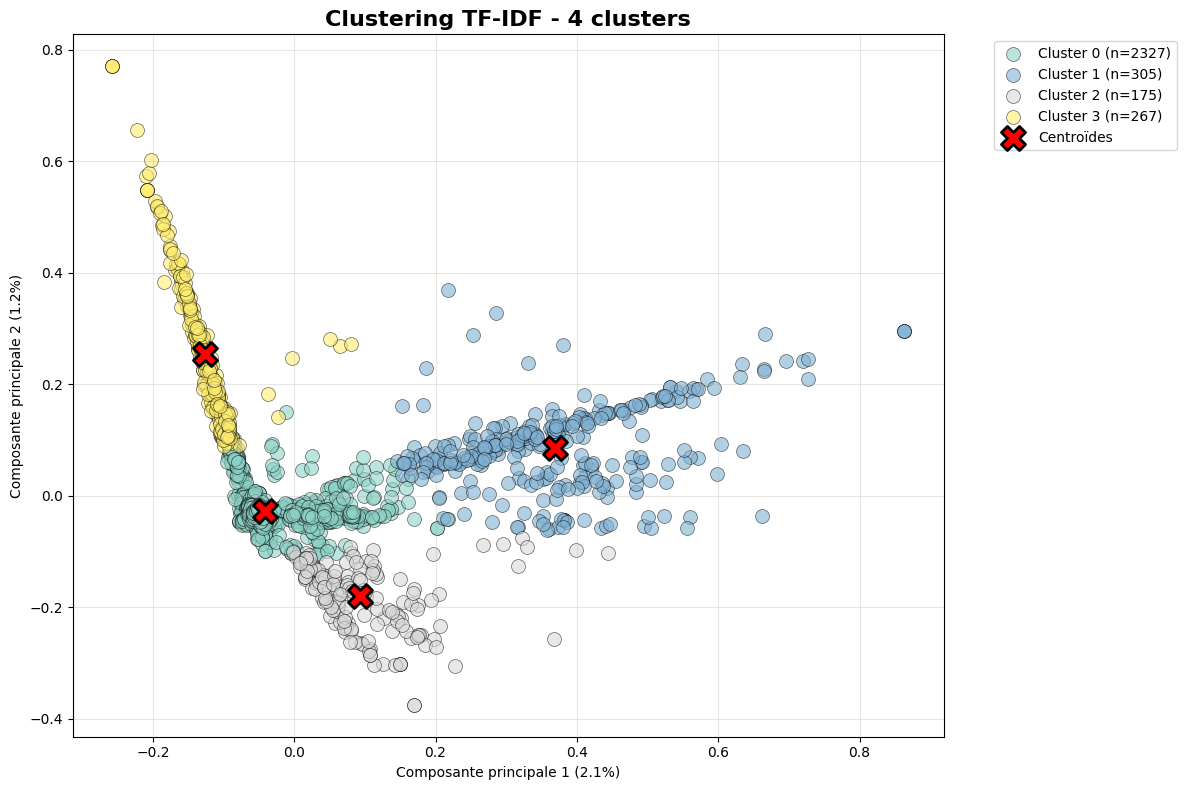

In [35]:
import numpy as np


pca = PCA(n_components=2, random_state=42)
tfidf_dense = tfidf_matrix.toarray()
coords_2d = pca.fit_transform(tfidf_dense)

# Ajouter les coordonnées au DataFrame
df['x'] = coords_2d[:, 0]
df['y'] = coords_2d[:, 1]

# Créer le graphique
plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, best_k))

for i in range(best_k):
    cluster_data = df[df['cluster'] == i]
    plt.scatter(
        cluster_data['x'], 
        cluster_data['y'],
        c=[colors[i]], 
        label=f'Cluster {i} (n={len(cluster_data)})',
        alpha=0.6,
        s=100,
        edgecolors='black',
        linewidth=0.5
    )

# Ajouter les centroïdes
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centroids_2d[:, 0], 
    centroids_2d[:, 1],
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Centroïdes',
    zorder=5
)

plt.title(f'Clustering TF-IDF - {best_k} clusters', fontsize=16, fontweight='bold')
plt.xlabel(f'Composante principale 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Composante principale 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [36]:
df[df.cluster == 1].head(20)

,Unnamed: 0,comments,Service,clean_sentence,sentiment,cluster,nb_mots,x,y
140,140,C’est pour cela moi j’aime\nWave Côte d'Ivoire...,Orange Money,aimer wave côte ivoire barcelonais orange maudia,POSITIVE,1,7,0.380687,0.270893
197,197,Le DG d'Orange Côte d'Ivoire est madrilèn c'es...,Orange Money,orange côte ivoire madrilèn clair,NEUTRAL,1,5,0.252762,0.288410
278,278,1.0 POUR LA CÔTE D'IVOIRE,Orange Money,côte ivoire,NEUTRAL,1,2,0.666082,0.290808
281,281,3-1 pour la côte d'ivoire avec une passe décis...,Orange Money,côte ivoire passe décisif simon adingra,NEGATIVE,1,6,0.225698,0.093742
286,286,Côte d’Ivoire 3- 1 burundi,Orange Money,côte ivoire burundi,NEUTRAL,1,3,0.305199,0.130680
295,295,3#0 en faveur de la côte d'ivoire\ntoujours fier,Orange Money,faveur côte ivoire fier,POSITIVE,1,4,0.247044,0.102427
326,326,Côte d’Ivoire gagne sans encaisser de but en t...,Orange Money,côte ivoire gagner encaisser but cas haller bu...,NEUTRAL,1,8,0.248401,0.106397
372,372,Nul première mis temps\nEt victoire pour la Cô...,Orange Money,mettre temps victoir côte ivoire bon vendredi ...,POSITIVE,1,9,0.198576,0.088709
373,373,Victoire pour la côte d'ivoire 1 à 0 premier m...,Orange Money,victoire côte ivoire côte ivoire fin match,NEGATIVE,1,7,0.340330,0.145790
379,379,La Côte d'Ivoire va perdre ce match\nCôte d’Iv...,Orange Money,côte ivoire perdre match côte ivoire burundi,NEGATIVE,1,7,0.409903,0.179845


In [37]:
df.to_csv('final_database.csv', index=False)